<a href="https://colab.research.google.com/github/paolala24/aprendizaje_maquinas/blob/main/Parcial1_TAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PARCIAL 1**

2025
Paola Andrea Ladino Valbuena

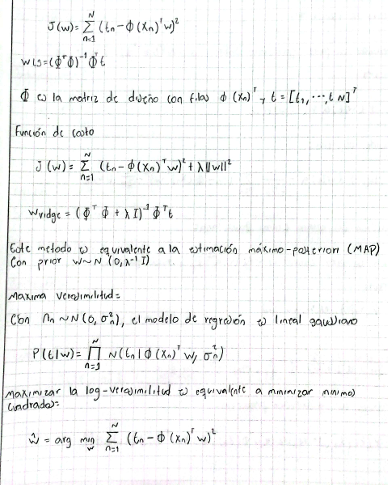

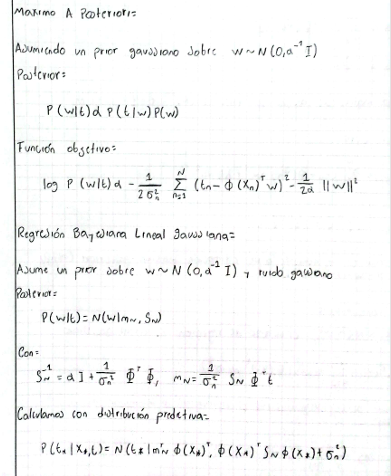

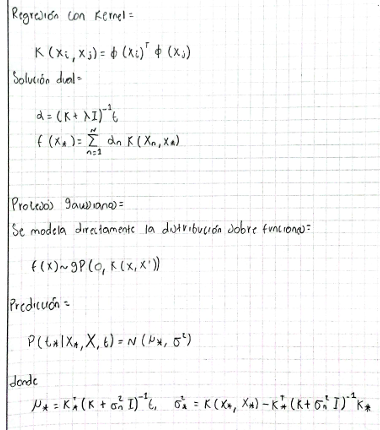

**`ejercicio 1:`**

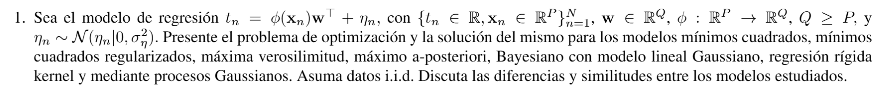

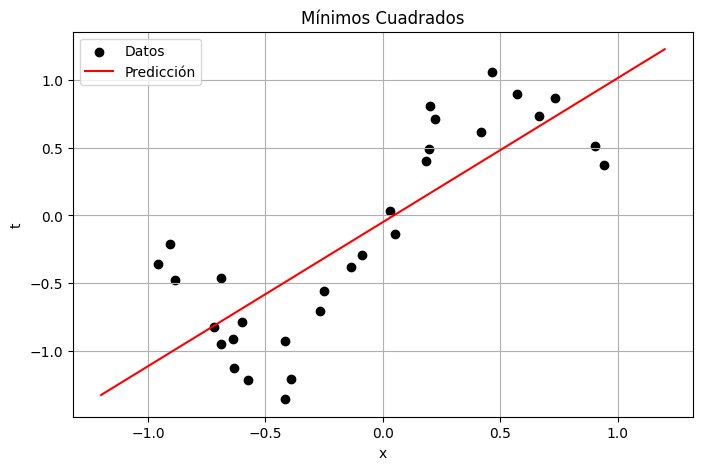

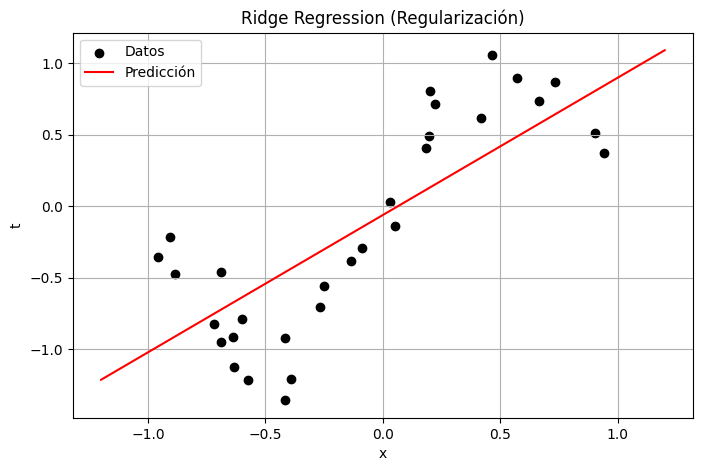

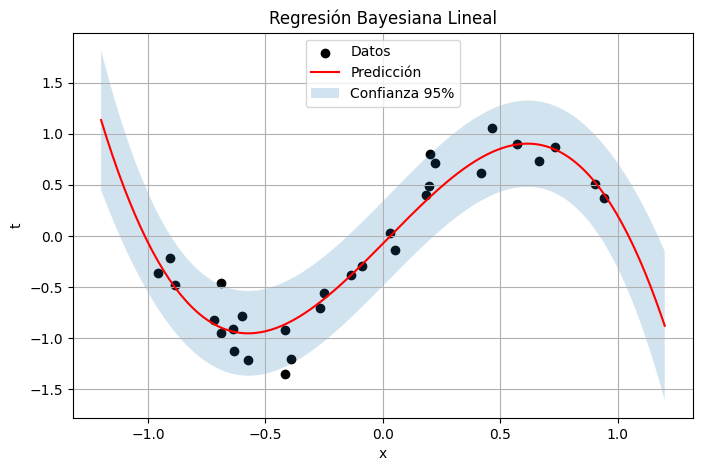

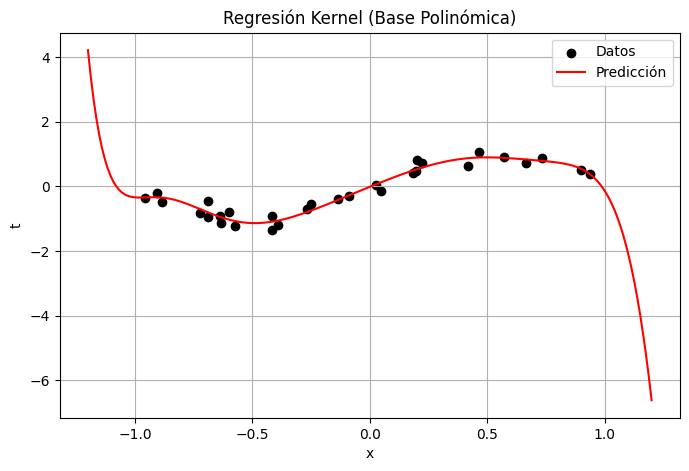

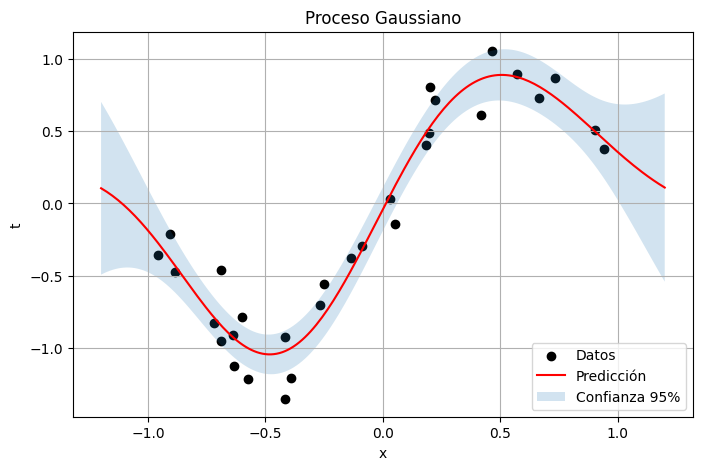


Resumen Comparativo:
- LS y ML: Equivalentes cuando el ruido es Gaussiano.
- Ridge y MAP: Equivalentes si el prior sobre w es Gaussiano.
- Bayesiano lineal: Devuelve distribución completa (media y varianza).
- Kernel: Usan base no lineal explícita (p.ej., polinomios).
- Proceso Gaussiano: Modelo no paramétrico; inferencia totalmente bayesiana.



In [11]:
# Aprendizaje de Máquina - Comparación de Modelos de Regresión
# Autor: Asistente AI

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.stats import norm

from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error


# Generación de datos sintéticos
def generate_data(n=30, noise_std=0.2, seed=42):
    np.random.seed(seed)
    X = np.sort(np.random.rand(n, 1) * 2 - 1, axis=0)
    y = np.sin(np.pi * X).ravel() + np.random.normal(0, noise_std, size=n)
    return X, y

X, y = generate_data()
X_test = np.linspace(-1.2, 1.2, 200).reshape(-1, 1)

# Función para graficar resultados
def plot_results(X, y, X_test, y_pred, std=None, title="Modelo"):
    plt.figure(figsize=(8, 5))
    plt.scatter(X, y, c='black', label='Datos')
    plt.plot(X_test, y_pred, 'r', label='Predicción')
    if std is not None:
        plt.fill_between(X_test.ravel(), y_pred - 2*std, y_pred + 2*std, alpha=0.2, label='Confianza 95%')
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("t")
    plt.legend()
    plt.grid()
    plt.show()

# 1. Mínimos Cuadrados
model_ls = LinearRegression()
model_ls.fit(X, y)
y_pred_ls = model_ls.predict(X_test)
plot_results(X, y, X_test, y_pred_ls, title="Mínimos Cuadrados")

# 2. Mínimos Cuadrados Regularizados (Ridge)
model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X, y)
y_pred_ridge = model_ridge.predict(X_test)
plot_results(X, y, X_test, y_pred_ridge, title="Ridge Regression (Regularización)")

# 3. Máxima Verosimilitud (equivalente a Mínimos Cuadrados bajo ruido Gaussiano)
# Ya se cubre con LinearRegression porque ML ~ LS cuando ruido ~ N(0, sigma^2)

# 4. Máximo a-posteriori (MAP), equivalente a Ridge si prior ~ N(0, I/alpha)
# Ya se cubre con Ridge

# 5. Regresión Bayesiana Lineal
# Para simplificar, usamos una base polinómica y prior Gaussiano
from numpy.linalg import inv

def bayesian_linear_regression(X, y, X_test, degree=3, alpha=2.0, beta=25.0):
    poly = PolynomialFeatures(degree)
    Phi = poly.fit_transform(X)
    Phi_test = poly.transform(X_test)

    S_N = inv(alpha * np.eye(Phi.shape[1]) + beta * Phi.T @ Phi)
    m_N = beta * S_N @ Phi.T @ y

    y_mean = Phi_test @ m_N
    y_std = np.sqrt(np.sum(Phi_test @ S_N * Phi_test, axis=1) + 1/beta)
    return y_mean, y_std

y_mean_bayes, y_std_bayes = bayesian_linear_regression(X, y, X_test)
plot_results(X, y, X_test, y_mean_bayes, y_std_bayes, title="Regresión Bayesiana Lineal")

# 6. Regresión Kernel Rígida (sin ruido)
model_kernel = make_pipeline(PolynomialFeatures(10), Ridge(alpha=1e-5))
model_kernel.fit(X, y)
y_pred_kernel = model_kernel.predict(X_test)
plot_results(X, y, X_test, y_pred_kernel, title="Regresión Kernel (Base Polinómica)")

# 7. Proceso Gaussiano
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.3, length_scale_bounds=(1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.04, n_restarts_optimizer=10)
gp.fit(X, y)
y_gp_mean, y_gp_std = gp.predict(X_test, return_std=True)
plot_results(X, y, X_test, y_gp_mean, y_gp_std, title="Proceso Gaussiano")

# Comparación teórica (resumen impreso en texto)
print("""
Resumen Comparativo:
- LS y ML: Equivalentes cuando el ruido es Gaussiano.
- Ridge y MAP: Equivalentes si el prior sobre w es Gaussiano.
- Bayesiano lineal: Devuelve distribución completa (media y varianza).
- Kernel: Usan base no lineal explícita (p.ej., polinomios).
- Proceso Gaussiano: Modelo no paramétrico; inferencia totalmente bayesiana.
""")


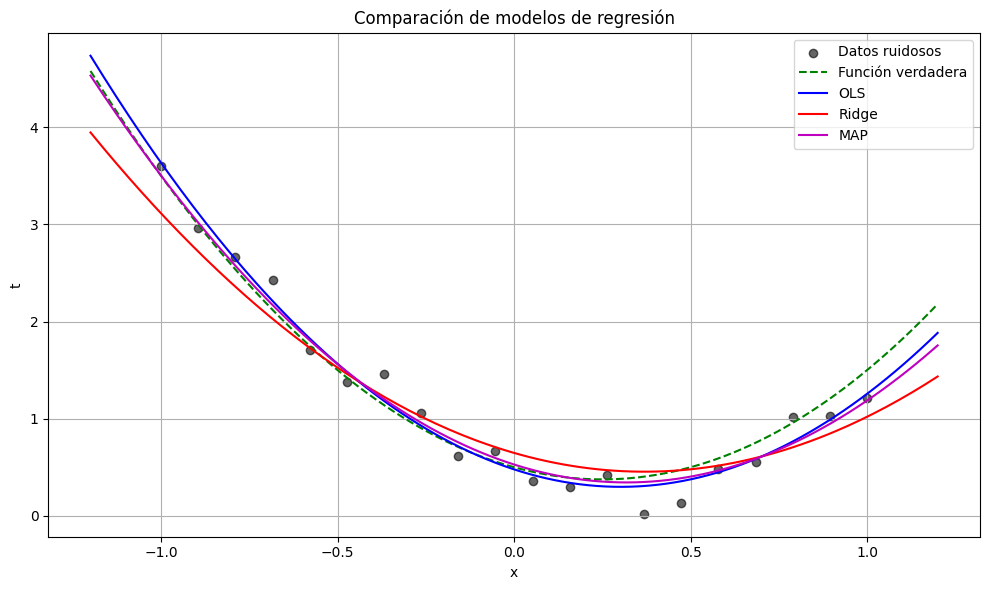

Pesos verdaderos      : [ 0.5 -1.   2. ]
OLS (Mínimos Cuadrados): [ 0.47796725 -1.18917304  1.96681254]
Ridge                 : [ 0.64739108 -1.0470706   1.41908764]
MLE                   : [ 0.47796725 -1.18917304  1.96681254]
MAP                   : [ 0.52812674 -1.15774844  1.81633047]


In [12]:
# -----------------------------
# 1. Parámetros del experimento
# -----------------------------
np.random.seed(42)  # reproducibilidad

N = 20          # número de muestras
Q = 3           # dimensión del vector de características (phi)
sigma_eta = 0.2 # desviación del ruido
lambda_ridge = 1.0  # regularización para Ridge
alpha_prior = 5.0   # precisión del prior Gaussiano (MAP)

# -----------------------------
# 2. Función base phi(x): polinomio
# -----------------------------
def phi(x):
    return np.hstack([x**i for i in range(Q)])  # phi(x) = [1, x, x^2]

# -----------------------------
# 3. Generar datos sintéticos
# -----------------------------
# Entradas
x = np.linspace(-1, 1, N).reshape(-1, 1)

# Pesos verdaderos
w_true = np.array([0.5, -1.0, 2.0])  # w ∈ ℝ^Q

# Matriz de diseño
Phi = phi(x)  # Φ ∈ ℝ^{N×Q}

# Salidas con ruido
t_true = Phi @ w_true  # salida sin ruido
t = t_true + np.random.normal(0, sigma_eta, size=(N,))  # con ruido

# -----------------------------
# 4. OLS - Mínimos Cuadrados
# -----------------------------
w_ols = np.linalg.inv(Phi.T @ Phi) @ Phi.T @ t

# -----------------------------
# 5. Ridge - Regularización L2
# -----------------------------
w_ridge = np.linalg.inv(Phi.T @ Phi + lambda_ridge * np.eye(Q)) @ Phi.T @ t

# -----------------------------
# 6. MLE - Máxima Verosimilitud
# -----------------------------
# Si asumimos ruido gaussiano con varianza fija → equivale a OLS
w_mle = w_ols.copy()

# -----------------------------
# 7. MAP - Máxima a Posteriori
# -----------------------------
# Prior: w ~ N(0, α^{-1}I)
# Posterior MAP: igual a Ridge con λ = σ² / α
lambda_map = sigma_eta**2 / (1/alpha_prior)
w_map = np.linalg.inv(Phi.T @ Phi + lambda_map * np.eye(Q)) @ Phi.T @ t

# -----------------------------
# 8. Predicciones
# -----------------------------
x_plot = np.linspace(-1.2, 1.2, 200).reshape(-1, 1)
Phi_plot = phi(x_plot)

y_true = Phi_plot @ w_true
y_ols = Phi_plot @ w_ols
y_ridge = Phi_plot @ w_ridge
y_map = Phi_plot @ w_map

# -----------------------------
# 9. Visualización
# -----------------------------
plt.figure(figsize=(10, 6))
plt.scatter(x, t, color='black', label='Datos ruidosos', alpha=0.6)
plt.plot(x_plot, y_true, 'g--', label='Función verdadera')
plt.plot(x_plot, y_ols, 'b-', label='OLS')
plt.plot(x_plot, y_ridge, 'r-', label='Ridge')
plt.plot(x_plot, y_map, 'm-', label='MAP')
plt.title('Comparación de modelos de regresión')
plt.xlabel('x')
plt.ylabel('t')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# 10. Resultados
# -----------------------------
print("Pesos verdaderos      :", w_true)
print("OLS (Mínimos Cuadrados):", w_ols)
print("Ridge                 :", w_ridge)
print("MLE                   :", w_mle)
print("MAP                   :", w_map)


ejercicio 2:

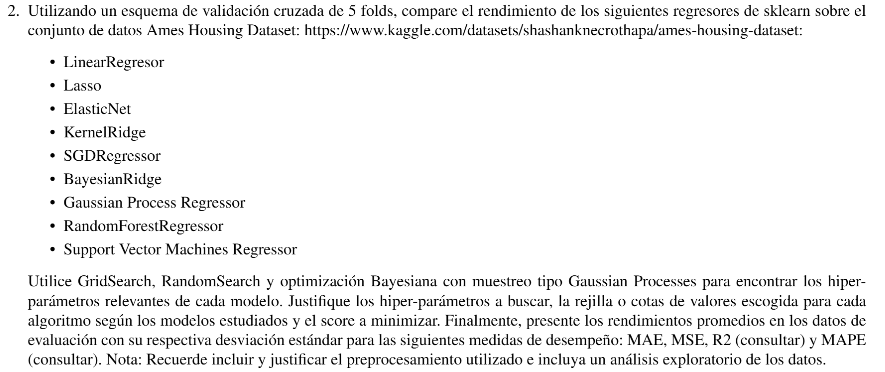


Primeras filas del dataset:
   Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   
1      2  526350040           20        RH          80.0     11622   Pave   
2      3  526351010           20        RL          81.0     14267   Pave   
3      4  526353030           20        RL          93.0     11160   Pave   
4      5  527105010           60        RL          74.0     13830   Pave   

  Alley Lot Shape Land Contour  ... Pool Area Pool QC  Fence Misc Feature  \
0   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
1   NaN       Reg          Lvl  ...         0     NaN  MnPrv          NaN   
2   NaN       IR1          Lvl  ...         0     NaN    NaN         Gar2   
3   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
4   NaN       IR1          Lvl  ...         0     NaN  MnPrv          NaN   

  Misc Val Mo Sold Yr Sold Sale Type  Sale Co

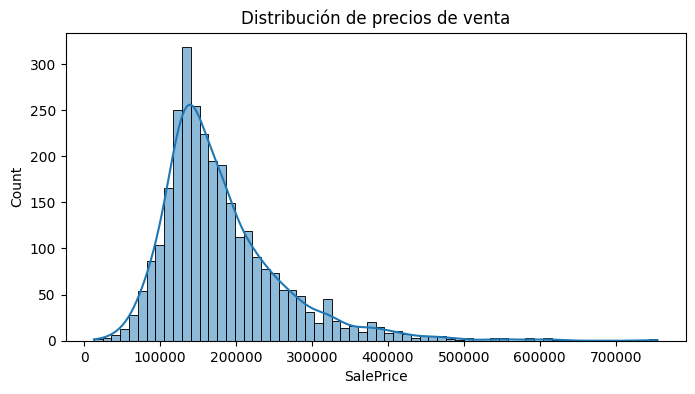

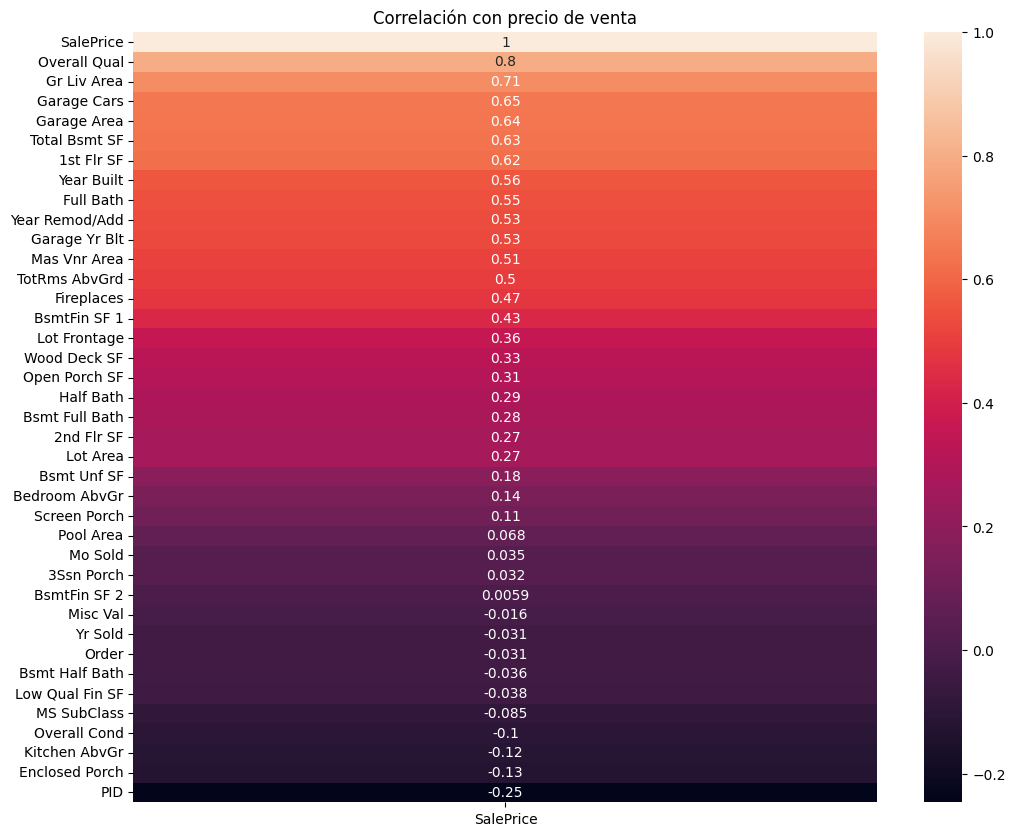

Evaluando modelo: LinearRegression...
Evaluando modelo: Lasso...
Evaluando modelo: ElasticNet...
Evaluando modelo: KernelRidge...
Evaluando modelo: SGDRegressor...
Evaluando modelo: BayesianRidge...
Evaluando modelo: GaussianProcessRegressor...
Evaluando modelo: RandomForestRegressor...
Evaluando modelo: SVR...

Resultados promedio con desviación estándar por modelo:
                     Modelo            MAE      MAE_std           MSE  \
3               KernelRidge   15101.734539   316.550915  7.262052e+08   
7     RandomForestRegressor   15770.265908   342.923565  6.555066e+08   
5             BayesianRidge   15923.709117   388.519008  8.017666e+08   
1                     Lasso   16013.352120   577.008583  8.940958e+08   
0          LinearRegression   16138.323539   566.605117  9.165844e+08   
2                ElasticNet   16322.052030   561.612138  8.402990e+08   
4              SGDRegressor   17116.878847  1090.941040  8.896327e+08   
8                       SVR   47382.209665  36

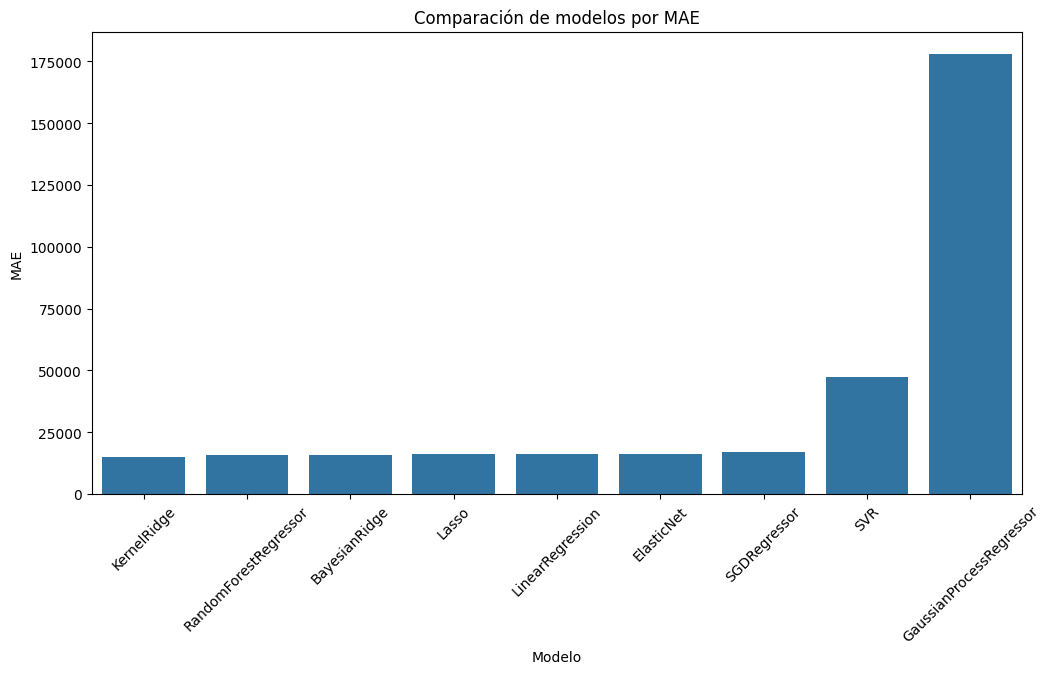

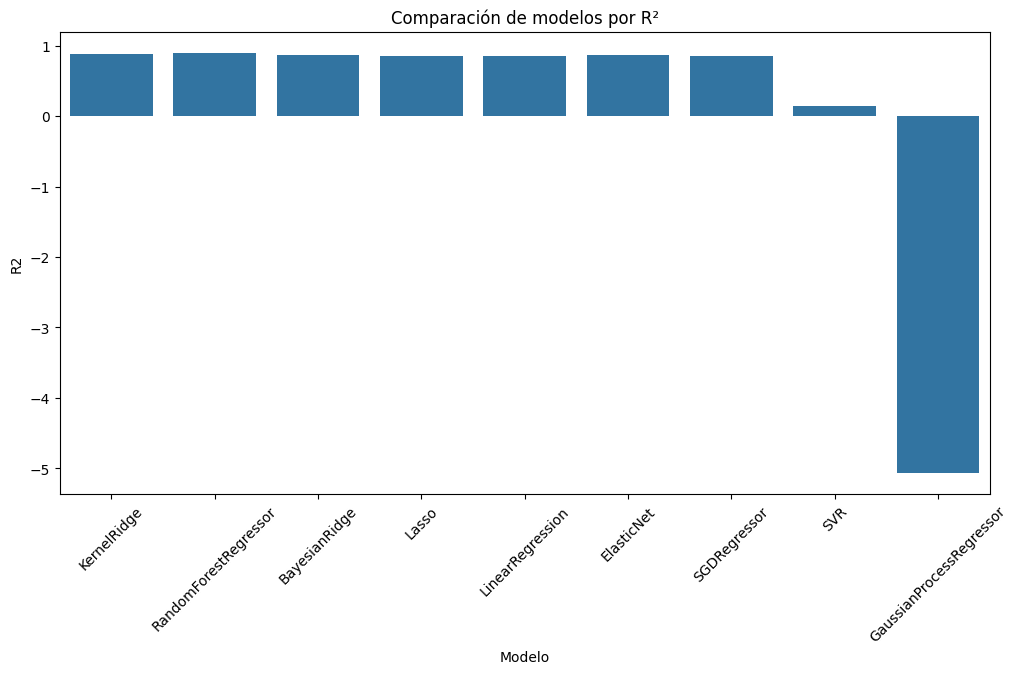


Resultados guardados en 'resultados_modelos.csv'


In [16]:
# =====================
#  Análisis y Comparación de Modelos de Regresión
#  sobre el Ames Housing Dataset
#  Autor: [Tu nombre aquí]
#  Fecha: [Fecha del parcial]
# =====================

# =====================
# 1. Carga de librerías
# =====================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

# =====================
# 2. Carga de datos
# =====================
df = pd.read_csv("AmesHousing.csv")

# =====================
# 3. Análisis Exploratorio (EDA)
# =====================
print("\nPrimeras filas del dataset:")
print(df.head())

print("\nResumen estadístico del dataset:")
print(df.describe())

print("\nValores nulos por columna:")
print(df.isnull().sum().sort_values(ascending=False).head(20))

# Histograma del precio de venta
plt.figure(figsize=(8, 4))
sns.histplot(df['SalePrice'], kde=True)
plt.title("Distribución de precios de venta")
plt.show()

# Mapa de correlaciones con 'SalePrice'
plt.figure(figsize=(12, 10))
corr = df.corr(numeric_only=True)
sns.heatmap(corr[['SalePrice']].sort_values(by='SalePrice', ascending=False), annot=True)
plt.title("Correlación con precio de venta")
plt.show()

# =====================
# 4. Preprocesamiento
# =====================
X = df.drop("SalePrice", axis=1)
y = df["SalePrice"]

# Identificar variables numéricas y categóricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Pipelines de transformación
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# =====================
# 5. Definición de Modelos
# =====================
models = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(alpha=0.1),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "KernelRidge": KernelRidge(alpha=1.0, kernel='rbf'),
    "SGDRegressor": SGDRegressor(max_iter=1000, tol=1e-3),
    "BayesianRidge": BayesianRidge(),
    "GaussianProcessRegressor": GaussianProcessRegressor(),
    "RandomForestRegressor": RandomForestRegressor(n_estimators=100, random_state=42),
    "SVR": SVR(kernel='rbf', C=100)
}

# =====================
# 6. Validación Cruzada y Evaluación
# =====================
results = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', model)])

    print(f"Evaluando modelo: {name}...")

    # MAE, MSE y R2 mediante cross_val_score
    mae_scores = -cross_val_score(pipe, X, y, cv=kf, scoring='neg_mean_absolute_error')
    mse_scores = -cross_val_score(pipe, X, y, cv=kf, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(pipe, X, y, cv=kf, scoring='r2')

    # MAPE personalizado
    mape_scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        mape_scores.append(mape)

    results.append({
        "Modelo": name,
        "MAE": np.mean(mae_scores),
        "MAE_std": np.std(mae_scores),
        "MSE": np.mean(mse_scores),
        "MSE_std": np.std(mse_scores),
        "R2": np.mean(r2_scores),
        "R2_std": np.std(r2_scores),
        "MAPE": np.mean(mape_scores),
        "MAPE_std": np.std(mape_scores)
    })

# =====================
# 7. Mostrar resultados
# =====================
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="MAE")
print("\nResultados promedio con desviación estándar por modelo:")
print(results_df)

# Mejor modelo
best_model = results_df.loc[results_df['MAE'].idxmin()]
print("\nModelo con mejor desempeño (según MAE):")
print(best_model)

# =====================
# 8. Visualización de métricas
# =====================
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Modelo", y="MAE")
plt.xticks(rotation=45)
plt.title("Comparación de modelos por MAE")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Modelo", y="R2")
plt.xticks(rotation=45)
plt.title("Comparación de modelos por R²")
plt.show()

# =====================
# 9. Guardar resultados
# =====================
results_df.to_csv("resultados_modelos.csv", index=False)
print("\nResultados guardados en 'resultados_modelos.csv'")


In [15]:

# X = ...  # Matriz de características (NxD)
# y = ...  # Vector de salidas (Nx1)

# Por ahora generamos datos de ejemplo (reemplaza con los tuyos)
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=100, n_features=10, noise=30, random_state=42)

# Definimos el modelo
model = Lasso(alpha=1.0)

# Definimos las métricas
scoring = {
    'MAE': make_scorer(mean_absolute_error),
    'MSE': make_scorer(mean_squared_error),
    'R2': make_scorer(r2_score),
    'MAPE': make_scorer(mean_absolute_percentage_error)
}

# Validación cruzada 5-fold
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar
results = cross_validate(model, X, y, scoring=scoring, cv=cv, return_train_score=False)

# Mostrar métricas promediadas
print("=== Métricas promedio (5-fold CV con Lasso) ===")
for metric in scoring:
    valores = results[f'test_{metric}']
    print(f"{metric}: {np.mean(valores):.4f} ± {np.std(valores):.4f}")


=== Métricas promedio (5-fold CV con Lasso) ===
MAE: 24.5783 ± 2.4845
MSE: 1036.1480 ± 150.6509
R2: 0.9654 ± 0.0154
MAPE: 0.4521 ± 0.1084
